In [133]:
import pandas as pd
import os
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

### Data Loads

In [134]:

camp_desc = pd.read_csv("../datasets/raw/campaign_desc.csv")
camp_table = pd.read_csv("../datasets/raw/campaign_table.csv")
causal_data = pd.read_csv("../datasets/raw/causal_data.csv")
coupon_redempt = pd.read_csv("../datasets/raw/coupon_redempt.csv")
coupon = pd.read_csv("../datasets/raw/coupon.csv")
hh_demographic = pd.read_csv("../datasets/raw/hh_demographic.csv")
product = pd.read_csv("../datasets/raw/product.csv")
transaction = pd.read_csv("../datasets/raw/transaction_data.csv")

In [135]:
data_list = [camp_desc, camp_table, causal_data, coupon_redempt, coupon, hh_demographic, product, transaction]

In [142]:
camp_table

,description,household_id,campaign_id
0,TypeA,17,26
1,TypeA,27,26
2,TypeA,212,26
3,TypeA,208,26
4,TypeA,192,26
...,...,...,...
7203,TypeC,1803,15
7204,TypeC,1082,15
7205,TypeC,942,15
7206,TypeC,855,15


In [138]:
def normalize_cols(df):
    df.columns = (df.columns
        .str.strip().str.lower()
        .str.replace(r"[^a-z0-9]+", "_", regex=True)   
        .str.replace(r"_+", "_", regex=True)           
        .str.strip("_")                                
    )


In [139]:
for data in data_list: 
    data = normalize_cols(data)

In [143]:
product.head() 

,product_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [144]:
hh_demographic.rename(columns={"household_key": "household_id"}, inplace=True)   
camp_table.rename(columns={"household_key": "household_id"}, inplace=True)
camp_desc.rename(columns={"campaign": "campaign_id"}, inplace=True)
camp_table.rename(columns={"campaign": "campaign_id"}, inplace=True)
coupon_redempt.rename(columns={"campaign": "campaign_id"}, inplace=True)
coupon.rename(columns={"campaign": "campaign_id"}, inplace=True)
transaction.rename(columns={"household_key": "household_id"}, inplace=True)
coupon_redempt.rename(columns={"household_key": "household_id"}, inplace=True)

In [145]:
if "household_id" in hh_demographic:  # unique oldugunu soyleyebliriz. FK olarak kullanılabilir.
    print("unique household_id oranı (hh):", hh_demographic["household_id"].nunique()/len(hh_demographic))

unique household_id oranı (hh): 1.0


In [147]:
if "campaign_id" in hh_demographic:
    print("unique campaign_id oranı (camp):", hh_demographic["campaign_id"].nunique()/len(hh_demographic))

### EDA

In [148]:
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

dfs = {
    "hh_demographic": hh_demographic,
    "product": product,
    "campaign_desc": camp_desc,
    "coupon": coupon,
    "coupon_redempt": coupon_redempt,
    "campaign_table": camp_table,
    "transaction_data": transaction,
    "causal_data": causal_data
}

In [149]:
data_list = [camp_desc, camp_table, causal_data, coupon_redempt, coupon, hh_demographic, product, transaction]

In [150]:
basket_fact = (dfs["transaction_data"]
               .groupby(["household_id","basket_id","day"], as_index=False)
               .agg(
                   n_items=("product_id","count"),
                   qty=("quantity","sum"),
                   sales=("sales_value","sum"),
                   retail_disc=("retail_disc","sum"),
                   coupon_disc=("coupon_disc","sum"),
                   coupon_match_disc=("coupon_match_disc","sum")
               ))
display(basket_fact.head())


,household_id,basket_id,day,n_items,qty,sales,retail_disc,coupon_disc,coupon_match_disc
0,1,27601281299,51,30,34,78.66,-16.54,-1.0,0.0
1,1,27774192959,67,12,14,41.10,-8.59,0.0,0.0
2,1,28024266849,88,12,13,26.90,-6.72,0.0,0.0
3,1,28106322445,94,23,32,63.43,-11.08,-1.5,-0.5
4,1,28235481967,101,17,20,53.45,-16.42,0.0,0.0


### Hanelerin Siparişlerinin İncelenmesi

* Her hanenin toplam harcaması, sepet sayısı ve ortalama sepet tutarları

In [152]:
transaction.head()

,household_id,basket_id,day,product_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [153]:
transaction.groupby("household_id").agg({"quantity": "sum"}).describe()

,quantity
count,2.500000e+03
mean,1.042742e+05
std,2.444561e+05
min,5.000000e+00
25%,7.700000e+02
50%,1.108450e+04
75%,8.764000e+04
max,4.479917e+06


In [157]:
t = dfs["transaction_data"][["household_id", "basket_id", "day", "sales_value"]].copy()

In [165]:
basket_sum = t.groupby("household_id").agg(
    total_sales=("sales_value", "sum"),
    basket_count=("basket_id", "nunique")
).reset_index() # household_key'i tekrar sütun yapmak için

In [166]:
basket_sum 

,household_id,total_sales,basket_count
0,1,4330.16,86
1,2,1954.34,45
2,3,2653.21,47
3,4,1200.11,30
4,5,779.06,40
...,...,...,...
2495,2496,4339.66,63
2496,2497,7111.98,221
2497,2498,2601.60,172
2498,2499,3394.07,90


In [167]:
basket_sum["Avg_basket_size"] = basket_sum["total_sales"] / basket_sum["basket_count"]
basket_sum.head()

,household_id,total_sales,basket_count,Avg_basket_size
0,1,4330.16,86,50.350698
1,2,1954.34,45,43.429778
2,3,2653.21,47,56.451277
3,4,1200.11,30,40.003667
4,5,779.06,40,19.476500


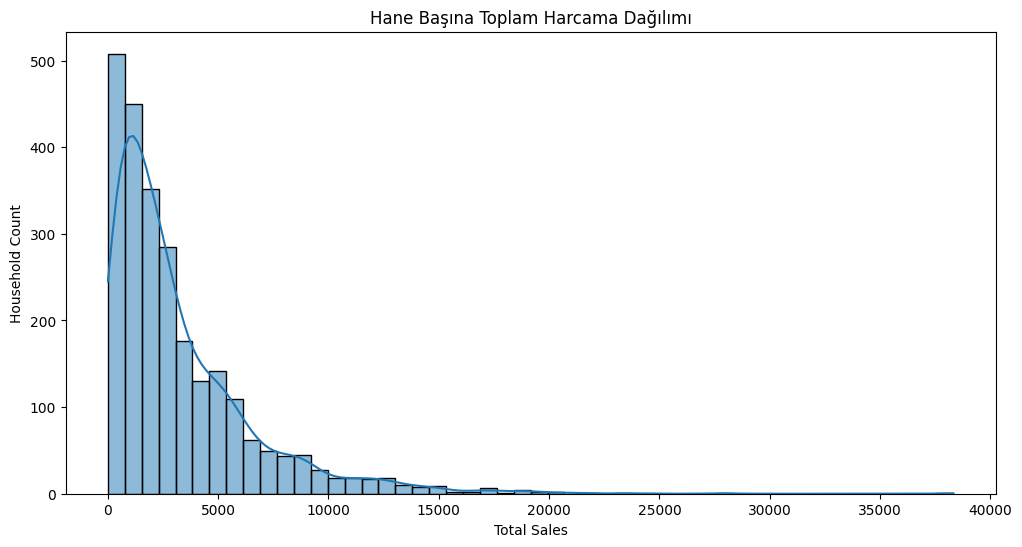

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
sns.histplot(basket_sum["total_sales"], bins=50, kde=True)
plt.title("Hane Başına Toplam Harcama Dağılımı")
plt.xlabel("Total Sales")
plt.ylabel("Household Count")
plt.show()

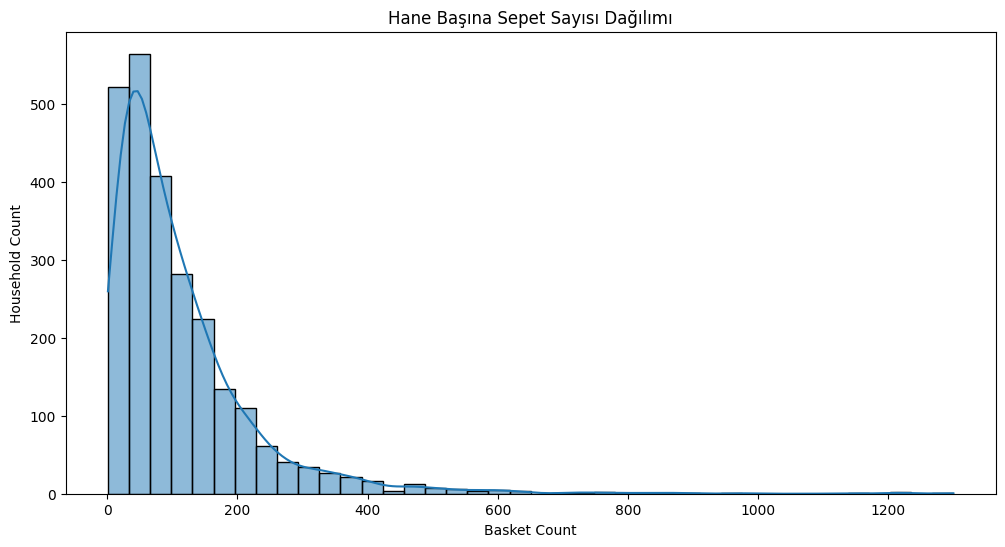

In [171]:
plt.figure(figsize=(12, 6))
sns.histplot(basket_sum["basket_count"], bins=40, kde=True)
plt.title("Hane Başına Sepet Sayısı Dağılımı")
plt.xlabel("Basket Count")
plt.ylabel("Household Count")
plt.show()

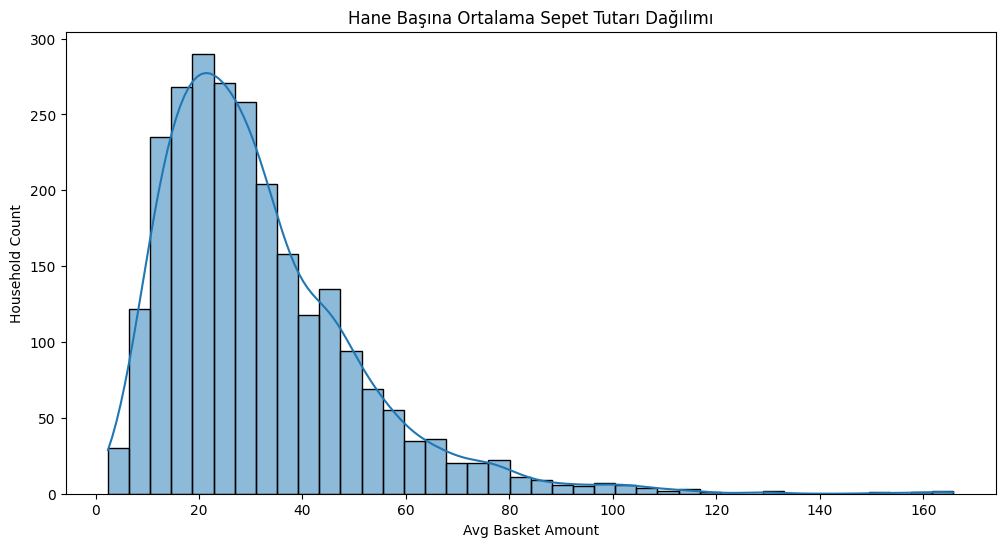

In [172]:
plt.figure(figsize=(12, 6))
sns.histplot(basket_sum["Avg_basket_size"], bins=40, kde=True)
plt.title("Hane Başına Ortalama Sepet Tutarı Dağılımı")
plt.xlabel("Avg Basket Amount" )
plt.ylabel("Household Count")
plt.show()

### Değişkenler Arası İlişkiler

* Alışveriş Sıklığı vs Toplam Harcama

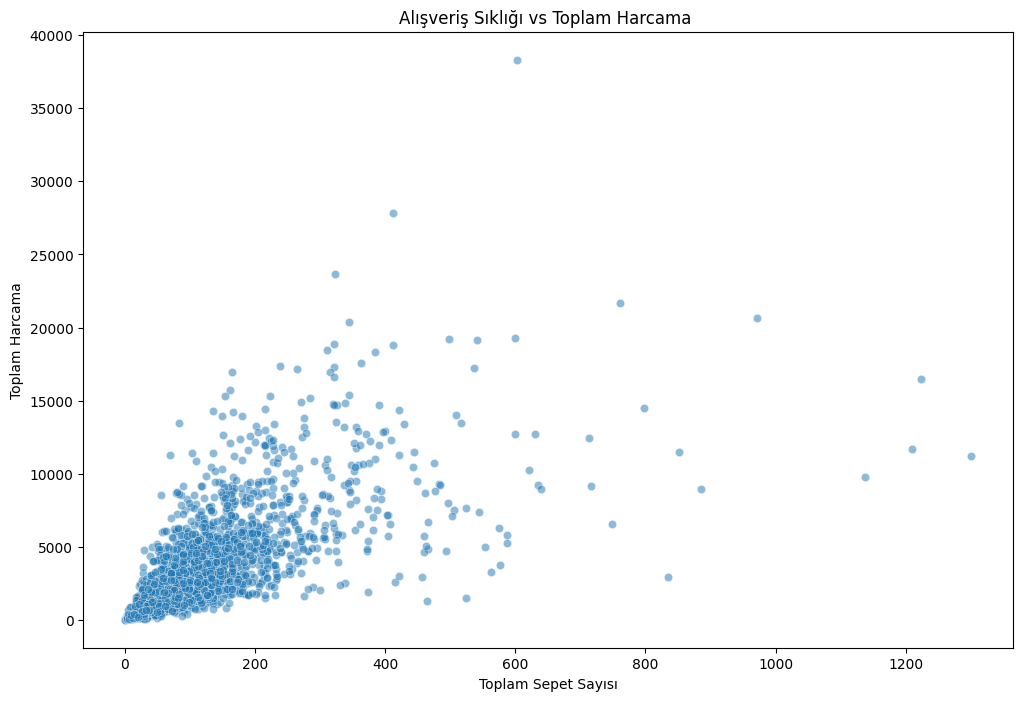

In [183]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=basket_sum, x="basket_count", y="total_sales", alpha=0.5)
plt.title("Alışveriş Sıklığı vs Toplam Harcama ")
plt.xlabel("Toplam Sepet Sayısı")
plt.ylabel("Toplam Harcama")
plt.show()

In [181]:
basket_sum

,household_id,total_sales,basket_count,Avg_basket_size
0,1,4330.16,86,50.350698
1,2,1954.34,45,43.429778
2,3,2653.21,47,56.451277
3,4,1200.11,30,40.003667
4,5,779.06,40,19.476500
...,...,...,...,...
2495,2496,4339.66,63,68.883492
2496,2497,7111.98,221,32.180905
2497,2498,2601.60,172,15.125581
2498,2499,3394.07,90,37.711889


* Ortalama Sepet Tutarı vs Toplam Harcama

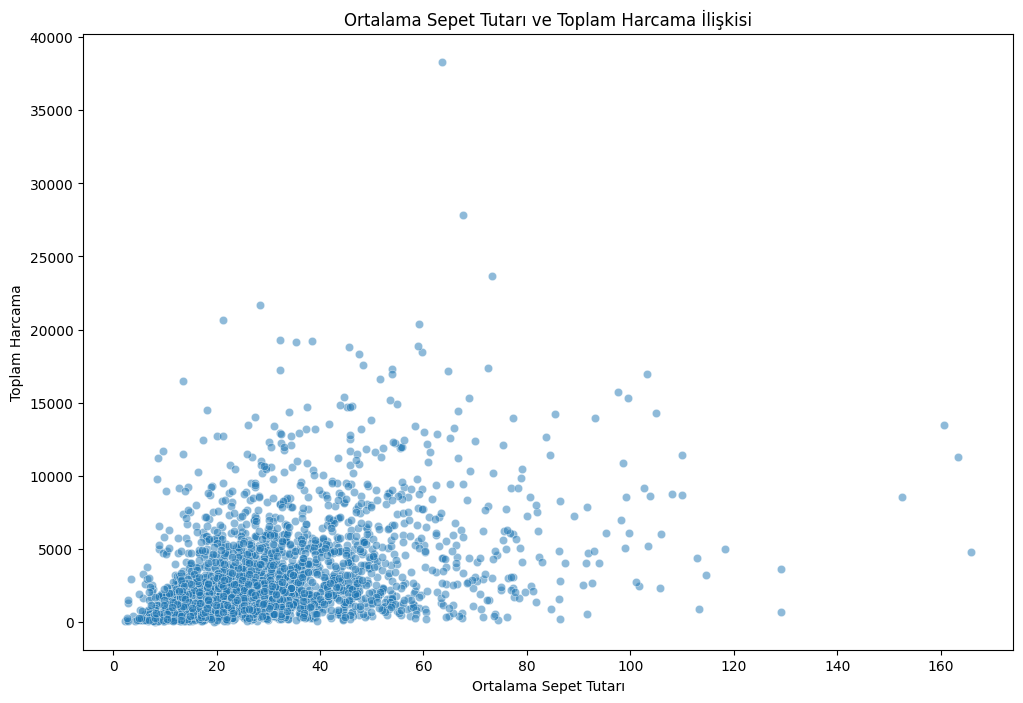

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=basket_sum, x="Avg_basket_size", y="total_sales", ascalpha=0.5)
plt.title("Ortalama Sepet Tutarı ve Toplam Harcama İlişkisi")
plt.xlabel("Ortalama Sepet Tutarı")
plt.ylabel("Toplam Harcama")
plt.show()